In [2]:
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

In [3]:
# Load inputs
import pandas as pd
df = pd.read_pickle("bau.pickle")

# Already have OAT, no need for wx.
#wx = pd.read_pickle("wxhydro2018.pickle")
#df = dfIn.merge(wx,how='outer',left_index=True,right_index=True)
#df = pd.DataFrame(df[df['OAT']<16]['OAT'].dropna())
#df.describe()

# Introduction

### Programmable Stat
My house is occupied 24/7, but everyone sleeps on the same schedule, so we could consider implementing a night setback program.  NSB in a fancy commercial BAS builds a lookup table so it know's each zone's thermal response speed to temperature perturbations, but most residential programmable stats only let you modify the RTSP on a schedule.

The hard way to estimate savings from a reduction in interior temperature is to model the heating system's behaviour.  It's hard because it requires a solid heat transfer model of the entire house, including ventilation, to carefully determine the heat loss, solving the differential equations to account for the exponential decay in transfer rates as temperatures approach steady state, and then trying to figure out how the heating system will compensate.

But fortunately, we already know how much heat is coming through the walls, and for a first-order approximation, heat loss is proportional to the delta-T between inside and outside. Our savings will be the time-weighted change in delta-T that we can produce with scheduling.

In my house, if I turn the heat off overnight with the OAT at around 10C, it will cool from 22 to 19 in about 8 hours.  It takes about three hours to warm back up from 18 no matter what the OAT.  

Applying Newton's law of cooling $T(t)=OAT+(RT-OAT)e^{-kt}$, we find 

\begin{align*}
T(8)=19 & =10+12e^{-8k}\\
ln(\frac{9}{12}) & =-8k\\
k & =0.036\\
\end{align*}

Heating dominates over losses, so the warmup rate is quite linear:

$$WARMUP\:RATE = 0.5\frac{^{\circ}C}{hr}$$

Bedtime's around 10PM and reveille around 7AM, so let's use a NSB schedule of 8PM-4AM.  We can tolerate things cooling off a bit just before bedtime, and the 4AM start guarantees that we'll have hit our "occupied" RTSP by 7AM on all but very cold nights.

In [4]:
# RTSP = 22 Occupied, 18 Night
#df = pd.DataFrame(bau['20170901':'20180301']['OAT'].dropna())
df.loc[(df.index.hour>=4)&(df.index.hour<20),'nrtsp']=22
df.loc[(df.index.hour<4)|(df.index.hour>=20),'nrtsp']=18

In [6]:
# Now calculate the sum of delta-T for BAU vs NSB (heating only)
df['bauhd']=df.rt-df.OAT
df.loc[df['bauhd']<0,'bauhd']=0
df['nsbhd']=df.nrt-df.OAT
df.loc[df['nsbhd']<0,'nsbhd']=0
#project savings
heatDTsaved = (df.bauhd.sum() - df.nsbhd.sum()) 
heatfracsaved = heatDTsaved/df.bauhd.sum()
print("Heating savings: %.2f%%"%(100*heatfracsaved))
#df.nsbhd.describe()
#df.bauhd.describe()

Heating savings: 7.61%


In [7]:
df.nsbhd.describe()
df.bauhd.describe()
df.nsbhd.sum() / df.bauhd.sum()

count    8760.000000
mean       10.333060
std         4.850989
min         0.000000
25%         6.171439
50%        10.998450
75%        14.100000
max        23.900000
Name: nsbhd, dtype: float64

count    8760.000000
mean       11.183767
std         5.257502
min         0.000000
25%         6.500000
50%        12.000000
75%        15.500000
max        25.000000
Name: bauhd, dtype: float64

0.9239337241165206

The following chart illustrates how much more quickly things cool down when it's cold out.  The green squiggle shows the sum of reduced $\Delta T$ values (RT vs OAT) over two periods of three days, as compared to a constant RT of 22C.

Text(0,0.5,'Degrees C')

Text(0,0.5,'Sum of saved degree-hours')

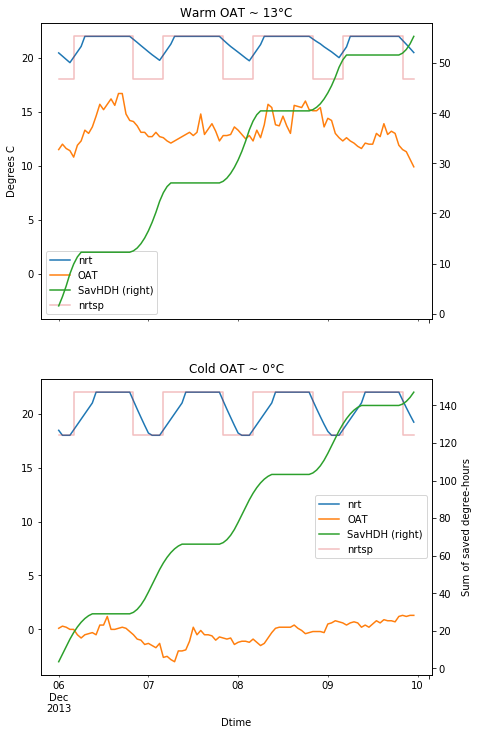

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,12),sharey=True)
#fig.suptitle("Typical NSB HDH Savings")

dd=pd.DataFrame(df['2013-05-10':'2013-05-13'])
dd['SavHDH'] = (dd.rt-dd.nrt).cumsum()
a=0

tit="Warm OAT ~ %d°C"%dd.OAT.mean()
ax=dd[['nrt','OAT','SavHDH']].plot(ax=axes[a],kind='line',title=tit,secondary_y='SavHDH')
dd[['nrtsp']].plot(ax=axes[a],kind='line',drawstyle="steps-post",alpha=.3)
lines = ax.get_lines() + ax.right_ax.get_lines() # Need to add "lines" from right ax to label it.
#ax.legend(lines,['RT','OAT','SavHDH','RTSP'])
ax.set_ylabel('Degrees C')

dd=pd.DataFrame(df['2013-12-6':'2013-12-9'])
dd['SavHDH'] = (dd.rt-dd.nrt).cumsum()
a=1
tit="Cold OAT ~ %d°C"%dd.OAT.mean()
ax=dd[['nrt','OAT','SavHDH']].plot(ax=axes[a],kind='line',title=tit,secondary_y='SavHDH')
dd[['nrtsp']].plot(ax=axes[a],kind='line',drawstyle="steps-post",alpha=.3)
lines = ax.get_lines() + ax.right_ax.get_lines() # Need to add "lines" from right ax to label it.
#ax.legend(lines,['RT','OAT','SavHDH','RTSP'])
ax.right_ax.set_ylabel('Sum of saved degree-hours')

plt.show()


## NSB Hourly Consumption
The average annual savings number is nice to know, but what we *really* want to know is the new hourly consumption -- otherwise we have no way of knowing how the NSB will interact with other measures.

We can get fairly close with the assumptions we've already made:

  - Cooldown: hourly heating load is 0
  - Steady state: same as BAU, but with savings proportional to the reduction in $\Delta T$ vs OAT.
  - Total heating savings $BAU \rightarrow NSB$ are known from the approximation above
  - We can now solve for the sum of heating loads during warmup periods
    - distribute this sum between all warmup periods
    - pro rate such that hours with a fractional warmup get a fractional share.
  
\begin{align}
\sum H_{NSB}	=\sum H_{BAU}\times(1-Savings\sim6.5\%)\\
H_{NSB}	=H_{cooldown}+H_{SS}+H_{warmup}\\
\begin{aligned}H_{cool} &=0\\
H_{SS} & =H_{BAU}\times\left(1-\frac{\Delta T_{NSB}}{\Delta T_{BAU}}\right)\\
\end{aligned}\\
\sum H_{warmup}	=\sum H_{BAU}(0.935)-\sum H_{SS}
\end{align}

Distribute as follows:

\begin{align}
\sum Hours_{warm}=\sum f(t) \begin{cases}
1 & \Delta T(t)\ge1C\\
\Delta T(t) & \Delta T(t)<1C
\end{cases}\\
H(t)=\frac{\sum H}{\sum Hours} \times f(t)\\
\end{align}


In [9]:
# This is a row operation to calculate the fractional savings.  
# No longer necessary, calculated above.
def saveDT(row):
    RTN=row.nrt
    RTB=row.rt
    OAT=row.OAT
    # Computes the fractional reduction in delta T for NSB as compared to BAU
    DTN=RTN-OAT
    DTB=RTB-OAT
    if(DTB<=0): return 0 # There are no savings possible if the BAU DT indicates no heating.
    if(DTN<=0): DTN=0 # Best we can do is turn off the heat and save 100%
    return (DTB-DTN)/DTB

# Categorize periods and calculate new heating load for each period
h = df[(df.hload!=0)].dropna()
# Set default values for cooling
h['cooldown']= h.nrt > h.nrtsp
h.loc[h.cooldown,'savefrac'] = 1
h.loc[h.cooldown,'nhload'] = 0 

#compute savings fraction and hload for the Steady State periods
# I think there's an error here.
h['ss']= h.nrt == h.nrtsp
#h['savefrac'] = 
h.loc[h.ss,'savefrac']=h[h.ss].apply(saveDT,axis=1)
h.loc[h.ss,'nhload']=h[h.ss]['hload'] * (1-h[h.ss]['savefrac'])

#now get ready for the warmup rows
h['warmup']= h.nrt < h.nrtsp

In [10]:
# calculate the expected total NSB heating load, and the number of hours over which it should be distributed
hw = pd.DataFrame(h[h.warmup])

# Count the whole and fractional hours where warmup occurs
hw['whrs'] = hw.nrtsp - hw.nrt # This is correct where DT<=1
hw.loc[hw.whrs>1,'whrs'] = 1 # Because whrs is 1 where DT>1
whrs = hw.whrs.sum()

# Total Warmup heating is expected NSB total, less expected NSB at SS.
expectedHnsb = h.hload.sum() * (1-heatfracsaved) 
expectedHss = h[h.ss].hload.sum()
expectHwarmup = expectedHnsb - expectedHss

# Now distribute the warmup load
HwarmPerWhr = expectHwarmup / whrs 
h.loc[hw.index,'nhload'] = (hw.whrs * HwarmPerWhr)

# There is an error here:
h.nhload.sum() / h.hload.sum()


0.9188191831627831

In [11]:
# These should match
#expectedHss 
#h.nhload[h.ss].sum()

# So should these
#expectHwarmup
#h.nhload[h.warmup].sum()

h.nhload.sum()

6369.993951481103

In [12]:
h.hload.sum()

6932.8047